#### Warning : code requres .csv files from here : https://www.kaggle.com/rounakbanik/the-movies-dataset  and a movie database api key

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import json
import ast
import math
from os.path import exists

In [3]:
#Credits
credits = pd.read_csv(".\credits.csv")
credits.drop_duplicates('id', inplace = True)
print("{0} {1} : {2}".format("credits.csv", credits.shape, credits.columns))
#Keywords
keywords = pd.read_csv(".\keywords.csv")
keywords.drop_duplicates('id', inplace = True)
print("{0} {1} : {2}".format("keywords.csv", keywords.shape, keywords.columns))
#Links
links = pd.read_csv(".\links.csv")
print("{0} {1} : {2}".format("links.csv", links.shape, links.columns))
#MetaData
metadata = pd.read_csv(".\movies_metadata.csv")
metadata.drop_duplicates('id', inplace = True)
print("{0} {1} : {2}".format("movies_metadata.csv", metadata.shape, metadata.columns))





def check_int(value):
    try:
        int(value)
        return np.NaN
    except ValueError:
        return value
    
def check_bool(value):
    try:
        bool(value)
        return np.NaN
    except ValueError:
        return value

credits.csv (45432, 3) : Index(['cast', 'crew', 'id'], dtype='object')
keywords.csv (45432, 2) : Index(['id', 'keywords'], dtype='object')
links.csv (45843, 3) : Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')
movies_metadata.csv (45436, 24) : Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')


C:\Users\Karl\AppData\Local\Temp/ipykernel_14744/3460031182.py:13: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(".\movies_metadata.csv")


### 1. Many types of ids in tables, verify 'id' is feature to merge on

In [4]:
#Find and drop invalid data in metadata

sub = metadata[['imdb_id','id','title']]
print("sub size {0}".format(sub.shape))

#tried to convert 'id' in metadata to int, but couldn't
#need to check values
invalid = sub['id'].apply(check_int).dropna()
print("Invalid Ids")
print(sub.loc[sub['id'].isin(invalid)])

cleansub = sub.loc[~sub['id'].isin(invalid)]
cleansub = cleansub.astype({'id':'int64'})

print("credits size {0}".format(credits.shape))
print("cleansub size {0}".format(cleansub.shape))
credit_meta = pd.merge(cleansub, credits, on='id')
print("credit_meta size {0}".format(credit_meta.shape))



credit_meta_keywords = pd.merge(credit_meta, keywords, on='id')

print()
print("Merged Tables")
print(credit_meta_keywords.dtypes)
print(credit_meta_keywords.columns)

sub size (45436, 3)
Invalid Ids
      imdb_id          id title
19730       0  1997-08-20   NaN
29503       0  2012-09-29   NaN
35587       0  2014-01-01   NaN
credits size (45432, 3)
cleansub size (45433, 3)
credit_meta size (45432, 5)

Merged Tables
imdb_id     object
id           int64
title       object
cast        object
crew        object
keywords    object
dtype: object
Index(['imdb_id', 'id', 'title', 'cast', 'crew', 'keywords'], dtype='object')


##### Verified can merge on 'id', which means 'links.csv' not needed

### 2 - Extract important features from each csv, and cast to types

In [5]:
metaSubset = metadata[['adult', 'budget', 'genres', 'id','imdb_id',
       'original_language','popularity', 'production_companies','production_countries', 
        'release_date', 'revenue', 'runtime','spoken_languages', 'status', 
        'title', 'video','vote_average', 'vote_count']]

metaSubset = metaSubset.loc[~sub['id'].isin(invalid)]
metaSubset = metaSubset.astype({'adult':'bool', 
                                'budget':'float', 
                                'id':'int64',
                                'imdb_id':'string',
                                'original_language':'string',
                                'popularity':'float',
                                'runtime':'float',
                               'title':'string',
                               'video':'bool'})

metaSubset['release_date'] = pd.to_datetime(metaSubset['release_date'])


#cut unreleased films, then remove column
metaSubset = metaSubset[metaSubset['status']=='Released']
metaSubset = metaSubset.drop(columns = 'status')

#missing revenue for 37619 movies out of 43000 in dataset, remove column
print("Number of missing revenue values: {0}".format(len(metaSubset[metaSubset['revenue']<= 0])))
metaSubset = metaSubset.drop(columns= 'revenue')

print("Number of missing budget values: {0}".format(len(metaSubset[metaSubset['budget']<= 0])))

print(metaSubset['production_countries'][0])

#genres, production_companies, production_countries come in as strings, interpret as objects(dictionaries, arrays, etc)
metaSubset['genres'] = metaSubset['genres'].apply(ast.literal_eval)
metaSubset['genreIds'] = metaSubset['genres'].apply(lambda x : [y['id'] for y in x])

metaSubset['production_companies'] = metaSubset['production_companies'].apply(lambda x : ast.literal_eval(x))
metaSubset['productionCompIds'] = metaSubset['production_companies'].apply(lambda x : [y['id'] for y in x])

metaSubset['production_countries'] = metaSubset['production_countries'].apply(lambda x : ast.literal_eval(x))
metaSubset['productionCountryId'] = metaSubset['production_countries'].apply(lambda x : [y['iso_3166_1'] for y in x])

Number of missing revenue values: 37600
Number of missing budget values: 36130
[{'iso_3166_1': 'US', 'name': 'United States of America'}]


### credits table
##### (this one takes some time)

In [6]:
creditsSub = credits[['cast', 'crew','id']]
print("Credit Sub Size = {0}".format(creditsSub.size))


def ParseCrew(crewString):
    c = ast.literal_eval(crewString)
    if(len(c) == 0):
        return []
    
    c = [ { key:value for (key,value) in x.items() if key in ['id','job','name']} \
          for x in c if x['job'] in ['Director', 'Screenplay','Editor']  ]
    return c

def GenerateCrewIds(crewArrayOfDict, job):
    
    if(len(crewArrayOfDict)==0):
        return []
    
    jobIds = []
    for crewMem in crewArrayOfDict:
         if 'id' in crewMem.keys() and \
            'job' in crewMem.keys() and \
            crewMem['job'] == job:
                jobIds.append(crewMem['id'])
    
    return jobIds


creditsSub['crew'] = creditsSub['crew'].apply(ParseCrew)
creditsSub['Ids_Director'] = creditsSub['crew'].apply(lambda x : GenerateCrewIds(x,'Director'))
creditsSub['Ids_Screenplay'] = creditsSub['crew'].apply(lambda x : GenerateCrewIds(x,'Screenplay'))
creditsSub['Ids_Editor'] = creditsSub['crew'].apply(lambda x : GenerateCrewIds(x,'Editor'))

print(creditsSub['crew'].head())


def ParseCast(castString):
    c = ast.literal_eval(castString)
    if(len(c) == 0):
        return []
    
    c = [ { key:value for (key,value) in x.items() if key in ['id','name']} \
          for x in c]
    return c
    
def GenerateCastIds(castArrayOfDict):
    if(len(castArrayOfDict)==0):
        return []
    
    castIds = []
    for castMember in castArrayOfDict:
         if 'id' in castMember.keys():
                castIds.append(castMember['id'])
                
    return castIds 
    
creditsSub['cast'] = creditsSub['cast'].apply(ParseCast)
creditsSub['Ids_Cast'] = creditsSub['cast'].apply(GenerateCastIds)


Credit Sub Size = 136296
0    [{'id': 7879, 'job': 'Director', 'name': 'John...
1    [{'id': 876, 'job': 'Screenplay', 'name': 'Jon...
2    [{'id': 26502, 'job': 'Director', 'name': 'How...
3    [{'id': 2178, 'job': 'Director', 'name': 'Fore...
4    [{'id': 17698, 'job': 'Screenplay', 'name': 'N...
Name: crew, dtype: object


In [7]:
print(creditsSub.size)

creditsSub.head()



318024


,cast,crew,id,Ids_Director,Ids_Screenplay,Ids_Editor,Ids_Cast
0,"[{'id': 31, 'name': 'Tom Hanks'}, {'id': 12898...","[{'id': 7879, 'job': 'Director', 'name': 'John...",862,[7879],"[12891, 7, 12892, 12893]","[8, 1168870]","[31, 12898, 7167, 12899, 12900, 7907, 8873, 11..."
1,"[{'id': 2157, 'name': 'Robin Williams'}, {'id'...","[{'id': 876, 'job': 'Screenplay', 'name': 'Jon...",8844,[4945],"[876, 56520, 56521]",[4951],"[2157, 8537, 205, 145151, 5149, 10739, 58563, ..."
2,"[{'id': 6837, 'name': 'Walter Matthau'}, {'id'...","[{'id': 26502, 'job': 'Director', 'name': 'How...",15602,[26502],[],[],"[6837, 3151, 13567, 16757, 589, 16523, 7166]"
3,"[{'id': 8851, 'name': 'Whitney Houston'}, {'id...","[{'id': 2178, 'job': 'Director', 'name': 'Fore...",31357,[2178],"[5144, 111118]",[],"[8851, 9780, 18284, 51359, 66804, 352, 87118, ..."
4,"[{'id': 67773, 'name': 'Steve Martin'}, {'id':...","[{'id': 17698, 'job': 'Screenplay', 'name': 'N...",11862,[56106],"[17698, 26160]",[68755],"[67773, 3092, 519, 70696, 59222, 18793, 14592,..."


### keywords table

In [8]:
def GenerateKeywordIds(keywordArrayOfDict):
    if(len(keywordArrayOfDict)==0):
        return []
    
    keywordIds = []
    for keyword in keywordArrayOfDict:
         if 'id' in keyword.keys():
                keywordIds.append(keyword['id'])
                
    return keywordIds

keywordsSub = keywords[['id','keywords']]
keywordsSub['keywords'] = keywordsSub['keywords'].apply(ast.literal_eval)
keywordsSub['Ids_Keywords'] = keywordsSub['keywords'].apply(GenerateKeywordIds)
keywordsSub.head()

,id,keywords,Ids_Keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[931, 4290, 5202, 6054, 9713, 9823, 165503, 17..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[10090, 10941, 15101, 33467, 158086, 158091]"
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[1495, 12392, 179431, 208510]"
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':...","[818, 10131, 14768, 15160, 33455]"
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[1009, 1599, 2246, 4995, 5600, 10707, 13149, 3..."


## Merge Tables

In [9]:
allData = metaSubset.merge(creditsSub, on='id')
allData = allData.merge(keywordsSub, on='id')

allData.head(2)

,adult,budget,genres,id,imdb_id,original_language,popularity,production_companies,production_countries,release_date,...,productionCompIds,productionCountryId,cast,crew,Ids_Director,Ids_Screenplay,Ids_Editor,Ids_Cast,keywords,Ids_Keywords
0,True,30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,tt0114709,en,21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,...,[3],[US],"[{'id': 31, 'name': 'Tom Hanks'}, {'id': 12898...","[{'id': 7879, 'job': 'Director', 'name': 'John...",[7879],"[12891, 7, 12892, 12893]","[8, 1168870]","[31, 12898, 7167, 12899, 12900, 7907, 8873, 11...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[931, 4290, 5202, 6054, 9713, 9823, 165503, 17..."
1,True,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,en,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,...,"[559, 2550, 10201]",[US],"[{'id': 2157, 'name': 'Robin Williams'}, {'id'...","[{'id': 876, 'job': 'Screenplay', 'name': 'Jon...",[4945],"[876, 56520, 56521]",[4951],"[2157, 8537, 205, 145151, 5149, 10739, 58563, ...","[{'id': 10090, 'name': 'board game'}, {'id': 1...","[10090, 10941, 15101, 33467, 158086, 158091]"


## Make Numeric Columns out of dictionary columns

### 1) Make Numeric Cast Columns

In [10]:
actor_columns = ['actors_AveRating_average',
                 'actors_AveRating_total',
                 'actors_RankedAveRating_average',
                 'actors_RankedAveRating_total',
                 'actors_Top3AveRating_total',
                 
                 'actors_VoteAve_average',
                 'actors_VoteAve_total',
                 'actors_RankedVoteAve_average',
                 'actors_RankedVoteAve_total',
                 'actors_Top3VoteAve_total',
                 
                 'actors_HistAve_average',
                 'actors_HistAve_total',
                 'actors_RankedHistAve_average',
                 'actors_RankedHistAve_total',
                 'actors_Top3HistAve_total',
                 
                 'actors_AllMovieAve_average',
                 'actors_AllMovieAve_total',
                 'actors_RankedAllMovieAve_average',
                 'actors_RankedAllMovieAve_total',
                 'actors_Top3RankedAllMovieAve_total',
                 
                 'actors_AllMovieVoteAve_average',
                 'actors_AllMovieVoteAve_total',
                 'actors_RankedAllMovieVoteAve_average',
                 'actors_RankedAllMovieVoteAve_total',
                 'actors_Top3RankedAllMovieVoteAve_total']

def GenerateCastPrestigeDataFrame(allMovies):

    ArrayOfDicts = []
    releaseOrder = allMovies.sort_values(by='release_date')
    rankings  = [10,10,8,5,5]
    allMoviesWithCast = allMovies[allMovies['cast'].notnull()]
    
    
    for i in range(len(releaseOrder)):
        thisRow = releaseOrder.iloc[i]
        
        thisDict = {}
        thisDict['id'] = thisRow['id']
        for col in actor_columns:
            thisDict[col] = np.nan
        
        
        previousMovies = releaseOrder.iloc[0:i]
        previousCast = previousMovies[previousMovies['cast'].notnull()]
        
        cast = thisRow['cast']
        
        if type(cast) is list:
            totRating = []
            totRankedRating = []
            Top3RatingTot = []
            
            totVoteAve =[]
            totRankedVoteAve =[]
            Top3VoteAveTot = []
            
            totActHistAve = []
            totRankedActHistAve = [] 
            Top3HistAveTot = []   
            
            allMovieRatingTot = []
            allMovieRankedRatingTot = []
            Top3AllMovieRatingTot =[]
            
            allMovieVoteAveTot = []
            allMovieRankedVoteAveTot = []
            Top3AllMovieVoteTot =[]
            
            
            for j in range(len(cast)):
            
                if(j>len(rankings)-1):
                    rank = 1;
                else:
                    rank = rankings[j]
                actor = cast[j]
                
                actorMoviesTilNow = previousMovies[[actor['id'] in x for x in previousCast['Ids_Cast']]]
                allActorMovies = allMoviesWithCast[[actor['id'] in x for x in allMoviesWithCast['Ids_Cast']]]
                
                #Actor is in Movies Previous to this one
                if len(actorMoviesTilNow) > 0:
                    thisActorRatingAve = sum(actorMoviesTilNow['vote_average']) / len(actorMoviesTilNow['vote_average'])
                    totRating.append(thisActorRatingAve)
                    totRankedRating.append(thisActorRatingAve*(rank))
                    if(j<3):
                        Top3RatingTot.append(thisActorRatingAve)

                    if sum(actorMoviesTilNow['vote_count'])>0:
                        thisActorVoteAve = sum(actorMoviesTilNow['vote_average'] * actorMoviesTilNow['vote_count']) / sum(actorMoviesTilNow['vote_count'])
                        totVoteAve.append(thisActorVoteAve)
                        totRankedVoteAve.append(thisActorVoteAve*(rank))

                        if j<3:
                            Top3VoteAveTot.append(thisActorVoteAve)


                    timeDiff = (thisRow['release_date'] - actorMoviesTilNow.iloc[0]['release_date']).total_seconds()
                    
                    if timeDiff >0:
                        lastMovie = actorMoviesTilNow.iloc[-1]
                        thisActorHistAve = sum(actorMoviesTilNow['vote_average'] *actorMoviesTilNow['release_date'].apply(lambda x: 1+ (x-lastMovie['release_date']).total_seconds()/timeDiff))
                        totActHistAve.append(thisActorHistAve)
                        totRankedActHistAve.append(thisActorHistAve*(rank))

                        if j<3:
                            Top3HistAveTot.append(thisActorHistAve)
                            
                if len(allActorMovies) > 0:
                    thisActorAllMovRatingAve = sum(allActorMovies['vote_average']) / len(allActorMovies['vote_average'])
                    allMovieRatingTot.append(thisActorAllMovRatingAve)
                    allMovieRankedRatingTot.append(thisActorAllMovRatingAve*(rank))
                    
                    if j <3:
                        Top3AllMovieRatingTot.append(thisActorAllMovRatingAve)

                    if sum(allActorMovies['vote_count'])>0:
                        thisActorAllMovieVoteAve = sum(allActorMovies['vote_average'] * allActorMovies['vote_count']) / sum(allActorMovies['vote_count'])
                        allMovieVoteAveTot.append(thisActorAllMovieVoteAve)
                        allMovieRankedVoteAveTot.append(thisActorAllMovieVoteAve*(rank))
                        
                        if j < 3:
                            Top3AllMovieVoteTot.append(thisActorAllMovieVoteAve)
                
            if len(totRating)>0:
                thisDict['actors_AveRating_average'] = sum(totRating)/len(totRating)
                thisDict['actors_AveRating_total'] = sum(totRating)
            if len(totRankedRating)>0:
                thisDict['actors_RankedAveRating_average'] = sum(totRankedRating)
                thisDict['actors_RankedAveRating_total'] = sum(totRankedRating)/len(totRankedRating)
            if len(Top3RatingTot)>0:
                thisDict['actors_Top3AveRating_total'] =sum(Top3RatingTot)
            
            if len(totVoteAve)>0:
                thisDict['actors_VoteAve_average'] = sum(totVoteAve)/len(totVoteAve)
                thisDict['actors_VoteAve_total'] = sum(totVoteAve)
            if len(totRankedVoteAve)>0:
                thisDict['actors_RankedVoteAve_average'] = sum(totRankedVoteAve)/len(totRankedVoteAve)
                thisDict['actors_RankedVoteAve_total'] = sum(totRankedVoteAve)
            if len(Top3VoteAveTot) > 0:
                thisDict['actors_Top3VoteAve_total'] = sum(Top3VoteAveTot)
            
            if len(totActHistAve)>0:
                thisDict['actors_HistAve_average'] = sum(totActHistAve)/len(totActHistAve)
                thisDict['actors_HistAve_total'] = sum(totActHistAve)
            if len(totRankedActHistAve)>0:
                thisDict['actors_RankedHistAve_average'] = sum(totRankedActHistAve)/len(totRankedActHistAve)
                thisDict['actors_RankedHistAve_total'] = sum(totRankedActHistAve)
            if len(Top3HistAveTot) > 0:
                thisDict['actors_Top3HistAve_total'] = sum(Top3HistAveTot)
                
            if len(allMovieRatingTot)> 0:
                thisDict['actors_AllMovieAve_average'] = sum(allMovieRatingTot)/len(allMovieRatingTot)     
                thisDict['actors_AllMovieAve_total'] = sum(allMovieRatingTot)
            if len(allMovieRankedRatingTot) > 0:
                thisDict['actors_RankedAllMovieAve_average'] = sum(allMovieRankedRatingTot)/len(allMovieRankedRatingTot)
                thisDict['actors_RankedAllMovieAve_total'] =  sum(allMovieRankedRatingTot)
            if len(Top3AllMovieRatingTot)>0:
                thisDict['actors_Top3RankedAllMovieAve_total'] = sum(Top3AllMovieRatingTot)
            
            if len(allMovieVoteAveTot) > 0:
                thisDict['actors_AllMovieVoteAve_average'] = sum(allMovieVoteAveTot)/len(allMovieVoteAveTot)       
                thisDict['actors_AllMovieVoteAve_total'] = sum(allMovieVoteAveTot)          
            if len(allMovieRankedVoteAveTot) > 0:
                thisDict['actors_RankedAllMovieVoteAve_average'] = sum(allMovieRankedVoteAveTot)/len(allMovieVoteAveTot)
                thisDict['actors_RankedAllMovieVoteAve_total'] = sum(allMovieRankedVoteAveTot)
            if len(Top3AllMovieVoteTot) > 0:
                thisDict['actors_Top3RankedAllMovieVoteAve_total'] = sum(Top3AllMovieVoteTot)
                
            
            ArrayOfDicts.append(thisDict)
        
        if(i %(len(releaseOrder)//1000) == 0):
            print("{0} percent".format(i*100/len(releaseOrder)))
    return pd.DataFrame(ArrayOfDicts)

if(exists('./ActorNumeric.csv')):
    actorNumericPrestige = pd.read_csv('./ActorNumeric.csv')
    actorNumericPrestige.drop_duplicates('id', inplace = True)
else:
    actorNumericPrestige = GenerateCastPrestigeDataFrame(allData)
    actorNumericPrestige = actorNumericPrestige.drop_duplicates('id')
    actorRankingFile = "ActorNumeric.csv"
    actorNumericPrestige.to_csv(actorRankingFile, sep=',', index=False)    

print(actorNumericPrestige.dropna().head())

        id  actors_AveRating_average  actors_AveRating_total  \
18  105157                  4.800000                4.800000   
29  104396                  3.550000                3.550000   
48  129865                  5.400000                5.400000   
53  133063                  5.483333               10.966667   
55  104471                  5.775000                5.775000   

    actors_RankedAveRating_average  actors_RankedAveRating_total  \
18                       48.000000                     48.000000   
29                       35.500000                     35.500000   
48                       54.000000                     54.000000   
53                      109.666667                     54.833333   
55                       57.750000                     57.750000   

    actors_Top3AveRating_total  actors_VoteAve_average  actors_VoteAve_total  \
18                    4.800000                4.800000              4.800000   
29                    3.550000                

### 2) Make Numeric Crew Columns

In [11]:
crewColumns = ['directorTot_AveRating',
               'directorTot_VoteAveRating',
               'directorTot_HistAveRating',
               'directorTot_AllAveRating',
               'directorTot_AllVoteAveRating',
               
               'screenwriterTot_AveRating',
               'screenwriterTot_VoteAveRating',
               'screenwriterTot_HistAveRating',
               'screenwriterTot_AllAveRating',
               'screenwriterTot_AllVoteAveRating',
               
               'editorTot_AveRating',
               'editorTot_VoteAveRating',
               'editorTot_HistAveRating',
               'editorTot_AllAveRating',
               'editorTot_AllVoteAveRating']

def GenerateCrewPrestigeDataFrame(allMovies):

    ArrayOfDicts = []
    releaseOrder = allMovies.sort_values(by='release_date')
    
    for i in range(len(releaseOrder)):
        thisRow = releaseOrder.iloc[i]
        
        thisDict = {}
        thisDict['id'] = thisRow['id']
        for col in crewColumns:
            thisDict[col] = np.nan
        
        previousMovies = releaseOrder.iloc[0:i]
        previousCast = previousMovies[previousMovies['crew'].notnull()]
        
        crew = thisRow['crew']
        
        if type(crew) is list:
            totRatingDir = []
            totVoteAveDir =[]
            totActHistAveDir = []
            totAllRatingDir = []
            totAllVoteAveDir = []
            
            totRatingScr = []
            totVoteAveScr =[]
            totActHistAveScr = []
            totAllRatingScr = []
            totAllVoteAveScr = []
            
            totRatingEdt = []
            totVoteAveEdt =[]
            totActHistAveEdt = []
            totAllRatingEdt = []
            totAllVoteAveEdt = []
                       
            
            for j in range(len(crew)):
            
                crewMem = crew[j]
                if 'job' in crewMem.keys():
                    temp = "nothing"
                else:
                    continue
                
                moviesTilNow = None
                if(crewMem['job']=='Director') :
                    moviesTilNow = previousMovies[[crewMem['id'] in x for x in previousCast['Ids_Director']]]
                elif(crewMem['job']=='Screenplay') :
                    moviesTilNow = previousMovies[[crewMem['id'] in x for x in previousCast['Ids_Screenplay']]]
                elif(crewMem['job']=='Editor') :
                    moviesTilNow = previousMovies[[crewMem['id'] in x for x in previousCast['Ids_Editor']]]
                else:
                    continue
                
                if len(moviesTilNow) > 0:
                    thisCrewMemRatingAve = sum(moviesTilNow['vote_average']) / len(moviesTilNow['vote_average'])

                    if sum(moviesTilNow['vote_count'])>0:
                        thisCrewMemVoteAve = sum(moviesTilNow['vote_average'] * moviesTilNow['vote_count']) / sum(moviesTilNow['vote_count'])

                    timeDiff = (thisRow['release_date'] - moviesTilNow.iloc[0]['release_date']).total_seconds()
                    if timeDiff >0:
                        thisCrewMemHistAve = sum(moviesTilNow['vote_average'] *moviesTilNow['release_date'].apply(lambda x: 1+ (x-moviesTilNow.iloc[-1]['release_date']).total_seconds()/timeDiff))

                    if(crewMem['job']=='Director') :
                        totRatingDir.append(thisCrewMemRatingAve)
                        totVoteAveDir.append(thisCrewMemVoteAve)
                        totActHistAveDir.append(thisCrewMemHistAve)
                    elif(crewMem['job']=='Screenplay') :
                        totRatingScr.append(thisCrewMemRatingAve)
                        totVoteAveScr.append(thisCrewMemVoteAve)
                        totActHistAveScr.append(thisCrewMemHistAve)  
                    elif(crewMem['job']=='Editor') :
                        totRatingEdt.append(thisCrewMemRatingAve)
                        totVoteAveEdt.append(thisCrewMemVoteAve)
                        totActHistAveEdt.append(thisCrewMemHistAve) 
                
                
                allCrewMovies = None
                if(crewMem['job']=='Director') :
                    allCrewMovies = allMovies[[crewMem['id'] in x for x in allMovies['Ids_Director']]]
                elif(crewMem['job']=='Screenplay') :
                    allCrewMovies = allMovies[[crewMem['id'] in x for x in allMovies['Ids_Screenplay']]]
                elif(crewMem['job']=='Editor') :
                    allCrewMovies = allMovies[[crewMem['id'] in x for x in allMovies['Ids_Editor']]]
                else:
                    continue
                    
                
                
                if  len(allCrewMovies) >0:
                    thisCrewMemAllRatingAve = sum(allCrewMovies['vote_average']) / len(allCrewMovies['vote_average'])

                    if sum(allCrewMovies['vote_count'])>0:
                        thisCrewMemAllVoteAve = sum(allCrewMovies['vote_average'] * allCrewMovies['vote_count']) / sum(allCrewMovies['vote_count'])

                    if(crewMem['job']=='Director') :
                        totAllRatingDir.append(thisCrewMemAllRatingAve)
                        totAllVoteAveDir.append(thisCrewMemAllVoteAve)
                    elif(crewMem['job']=='Screenplay') :
                        totAllRatingScr.append(thisCrewMemAllRatingAve)
                        totAllVoteAveScr.append(thisCrewMemAllVoteAve)
                    elif(crewMem['job']=='Editor') :
                        totAllRatingEdt.append(thisCrewMemAllRatingAve)
                        totAllVoteAveEdt.append(thisCrewMemAllVoteAve)
                        
            if len(totRatingDir)>0:
                thisDict['directorTot_AveRating'] = sum(totRatingDir)/len(totRatingDir)
            if len(totVoteAveDir)>0:
                thisDict['directorTot_VoteAveRating'] = sum(totVoteAveDir)/len(totVoteAveDir)
            if len(totActHistAveDir)>0:
                thisDict['directorTot_HistAveRating'] = sum(totActHistAveDir)/len(totActHistAveDir)
            if len(totAllRatingDir)>0:
                thisDict['directorTot_AllAveRating'] =sum(totAllRatingDir)/len(totAllRatingDir)
            if len(totAllVoteAveDir)>0:
                thisDict['directorTot_AllVoteAveRating'] = sum(totAllVoteAveDir)/len(totAllVoteAveDir)
                
            
            if len(totRatingScr)>0:
                thisDict['screenwriterTot_AveRating'] = sum(totRatingScr)/len(totRatingScr)
            if len(totVoteAveScr)>0:
                thisDict['screenwriterTot_VoteAveRating'] = sum(totVoteAveScr)/len(totVoteAveScr)
            if len(totActHistAveScr)>0:
                thisDict['screenwriterTot_HistAveRating'] = sum(totActHistAveScr)/len(totActHistAveScr)
            if len(totAllRatingScr)>0:
                thisDict['screenwriterTot_AllAveRating'] =sum(totAllRatingScr)/len(totAllRatingScr)
            if len(totAllVoteAveScr)>0:
                thisDict['screenwriterTot_AllVoteAveRating'] = sum(totAllVoteAveScr)/len(totAllVoteAveScr)
            
            if len(totRatingEdt)>0:
                thisDict['editorTot_AveRating'] = sum(totRatingEdt)/len(totRatingEdt)
            if len(totVoteAveEdt)>0:
                thisDict['editorTot_VoteAveRating'] = sum(totVoteAveEdt)/len(totVoteAveEdt)
            if len(totActHistAveEdt)>0:
                thisDict['editorTot_HistAveRating'] = sum(totActHistAveEdt)/len(totActHistAveEdt)
            if len(totAllRatingEdt)>0:
                thisDict['editorTot_AllAveRating'] =sum(totAllRatingEdt)/len(totAllRatingEdt)
            if len(totAllVoteAveEdt)>0:
                thisDict['editorTot_AllVoteAveRating'] = sum(totAllVoteAveEdt)/len(totAllVoteAveEdt)
            
            
            ArrayOfDicts.append(thisDict)
        
        if(i %(len(releaseOrder)//1000) == 0):
            print("{0} percent".format(i*100/len(releaseOrder)))
    return pd.DataFrame(ArrayOfDicts)

if(exists('./CrewNumeric.csv')):
    crewPrestige = pd.read_csv('./CrewNumeric.csv')
    crewPrestige.drop_duplicates('id', inplace=True)
else:
    crewPrestige = GenerateCrewPrestigeDataFrame(allData)
    crewPrestige = crewPrestige.drop_duplicates('id')
    crewRankingFile = "CrewNumeric.csv"
    crewPrestige.to_csv(crewRankingFile, sep=',', index=False)    

print(crewPrestige.dropna().head())

        id  directorTot_AveRating  directorTot_VoteAveRating  \
275   2078               5.900000                   6.020968   
279   2077               5.966667                   6.083154   
287  47650               5.990909                   6.116172   
298  31819               6.108000                   6.383293   
493   1405               6.133333                   6.250000   

     directorTot_HistAveRating  directorTot_AllAveRating  \
275                  60.068144                  6.540909   
279                  67.880846                  6.540909   
287                  74.573284                  6.540909   
298                  86.049590                  6.540909   
493                  12.240513                  6.483333   

     directorTot_AllVoteAveRating  screenwriterTot_AveRating  \
275                      7.774039                   6.100000   
279                      7.774039                   6.250000   
287                      7.774039                   6.333333  

### 3) Make Keyword and Genre Numeric Columns

In [12]:
def GenerateKeyWordAndGenreAveragesDataFrame(allMovies):

    ArrayOfDicts = []
    keywordAve = {}
    genreAve = {}
    
    for i in range(len(allMovies)):
        thisRow = allMovies.iloc[i]
        
        thisDict = {}
        thisDict['id'] = thisRow['id']
        thisDict['keywordTot_AveRating'] = np.nan
        thisDict['genreTot_RankedAveRating'] = np.nan
        
        AllKeywordRating =[]
        
        for keywordId in thisRow['Ids_Keywords']:
            if keywordId in keywordAve.keys():
                AllKeywordRating.append(keywordAve[keywordId])
            else:
                moviesWithKeyWord = allMovies[[keywordId in x for x in allMovies['Ids_Keywords']]]
                aveRating = sum(moviesWithKeyWord['vote_average']) / len(moviesWithKeyWord['vote_average'])
                keywordAve[keywordId] = aveRating
                AllKeywordRating.append(aveRating)
         
        AllGenreRating = []
        
        for genreId in thisRow['genreIds']:
            if genreId in genreAve.keys():
                AllGenreRating.append(genreAve[genreId])
            else:
                moviesWithGenre = allMovies[[genreId in x for x in allMovies['genreIds']]]
                aveRating = sum(moviesWithGenre['vote_average']) / len(moviesWithGenre['vote_average'])
                genreAve[genreId] = aveRating
                AllGenreRating.append(aveRating)

        if len(AllKeywordRating)>0:
            thisDict['keywordTot_AveRating'] = sum(AllKeywordRating)/len(AllKeywordRating)
        if len(AllGenreRating)>0:
            thisDict['genreTot_RankedAveRating'] = sum(AllGenreRating)/len(AllGenreRating)
            
            
        ArrayOfDicts.append(thisDict)
        
        if(i %(len(allMovies)//1000) == 0):
            print("{0} percent".format(i*100/len(allMovies)))
    return pd.DataFrame(ArrayOfDicts)

if(exists('./GenreAndKeywordNumeric.csv')):
    genreAndKeywordAve = pd.read_csv('./GenreAndKeywordNumeric.csv')
    genreAndKeywordAve.drop_duplicates('id', inplace=True)
else:
    genreAndKeywordAve = GenerateKeyWordAndGenreAveragesDataFrame(allData)
    keywordRankingFile = "GenreAndKeywordNumeric.csv"
    genreAndKeywordAve = genreAndKeywordAve.drop_duplicates('id')
    genreAndKeywordAve.to_csv(keywordRankingFile, sep=',', index=False)    

print(genreAndKeywordAve.dropna().head())


      id  keywordTot_AveRating  genreTot_RankedAveRating
0    862              6.378346                  5.913436
1   8844              6.078460                  5.739320
2  15602              6.144337                  5.756752
3  31357              5.532416                  5.803492
4  11862              6.111530                  5.712745


### 4) Merge in Numeric Columns

In [13]:
allData = allData.merge(actorNumericPrestige, on='id')
allData = allData.merge(crewPrestige, on='id')
allData = allData.merge(genreAndKeywordAve, on='id')

## Replace budget and revenue from the movie db

In [14]:
print("missing budget rows : {0}".format(len(allData[allData['budget']==0])))
allData = allData.drop(columns = 'budget')

missing budget rows : 36129


#### Import money File

In [15]:
from os.path import exists

if(exists('./money.csv')):
    df = pd.read_csv('./money.csv')
else:
    df = pd.DataFrame(columns=['id','budget', 'revenue'])

#### Read in missing data from themoviedb.org

In [16]:
import json
import time
f = open("./api.json")
j = json.load(f)

api = j['THE_MOVIE_DB_API']

from bs4 import BeautifulSoup
import requests as rq

print(api)

remaining = list(set(allData['id'])-set(df['id']))
budgetRev = []

for i in range(len(remaining)):
    movId = int(remaining[i])
    webread =rq.get('https://api.themoviedb.org/3/movie/{0}?api_key={1}'.format(movId,api)) 
    resp = webread.json()
    
    thisDict = {'id': movId}
                
    thisDict['budget'] = np.nan
    if('budget' in resp.keys() and int(resp['budget']) !=0):
        thisDict['budget'] = int(resp['budget'])
   
    thisDict['revenue'] = np.nan
    if('revenue' in resp.keys() and int(resp['revenue']) !=0):
        thisDict['revenue'] == int(resp['revenue'])
    
    budgetRev.append(thisDict.copy())

    if( len(remaining//1000)> 0 and i % (len(remaining)//1000) == 0):
        print("{0} percent complete".format(float(i*100)/float(len(remaining))))
        
if(len(budgetRev)>0):
    df2 = pd.DataFrame(budgetRev)
    df = pd.concat([df, df2], ignore_index=True)

df =df.drop_duplicates(subset=['id'])

f09db215292b8cd0e2396d9423025a0e


#### Check for missing ids (sanity check)

In [17]:
i= list(set(allData['id']) - set(df['id']))
print(len(i))
print(i[0:10])

df['id'].head()

0
[]


0      862.0
1     8844.0
2    15602.0
3    31357.0
4    11862.0
Name: id, dtype: float64

#### Save out money file

In [18]:
moneyfile = "money.csv"
df = df.drop_duplicates('id')
df.to_csv(moneyfile, sep=',', index = False)
print(len(df[~df['budget'].isna()]))
print(len(df[~df['revenue'].isna()]))
df.head()

10466
9409


,id,budget,revenue
0,862.0,30000000.0,373554033.0
1,8844.0,65000000.0,262797249.0
2,15602.0,25000000.0,71500000.0
3,31357.0,16000000.0,81452156.0
4,11862.0,NaN,76594107.0


### Import revenue from Box Office Mojo

#### Define web crawler function

In [19]:
def GetBoxOfficeMojoDomesticSales(ids):
    arrOfDicts = []
    count = 0
    print(len(ids))
    for movieid in ids:
        count += 1
        
        webread =rq.get('https://www.boxofficemojo.com/title/{0}/'.format(movieid))
        soup = BeautifulSoup(webread.content, "html.parser")
        mydivs = soup.find_all("div", {"class": "a-section a-spacing-none mojo-performance-summary-table"})

        for x in mydivs:
            money = x.find_all("div", {"class": "a-section a-spacing-none"})
            for y in money:
                moneyType = y.find("span", {"class":"a-size-small"})
                moneyVal = y.find("span",{"class":"money"})
                thisDict = {"imdb_id":movieid}
                if("Domestic" in moneyType.text and moneyVal != None):
                    m = moneyVal.text
                    m = m.replace(',','')
                    m = m.replace('$','')
                    m = m.replace('-','')
                    if(m != ""):
                        thisDict["Domestic"]=int(m)
                    else:
                        thisDict["Domestic"]=np.nan
                else:
                    thisDict["Domestic"]=np.nan
                arrOfDicts.append(thisDict.copy())
                        
        if(len(ids)//1000>0 and count % (len(ids)//1000) == 0):
            print("{0} % complete".format(count*100/len(ids)))
        
    frame = pd.DataFrame(arrOfDicts)
    return frame

#### Read in Box Office File

In [20]:
if(exists('./boxOffice.csv')):
    prevBoxOffice = pd.read_csv('./boxOffice.csv')
else:
    prevBoxOffice = pd.DataFrame(columns=['imdb_id','Domestic'])

#### Merge Money file 

In [21]:
allData.drop_duplicates(subset=['id'])
dataset = allData.merge(df, on='id')


#### Import missing Domestic Box Office data from BoxOfficeMojo
#### and filter out missing margin data into subDataSet

In [22]:
subDataSet = dataset[(~dataset['budget'].isna()) & (~dataset['revenue'].isna())]
subDataSet = subDataSet.assign(profit_margin = subDataSet.apply(lambda row: (row['revenue']-row['budget'])*100.0/row['budget'], axis=1).values)


budgetDataSet = dataset[~dataset['budget'].isna()]
missingIds = list(set(budgetDataSet['imdb_id'])- set(prevBoxOffice['imdb_id']))
print("Missing movie Domestic earnings count {0}".format(len(missingIds)))


if(len(missingIds)>0):
    boxOffice = GetBoxOfficeMojoDomesticSales(missingIds)
    boxOffice = pd.concat([prevBoxOffice,boxOffice], ignore_index=True)
else:
    boxOffice = prevBoxOffice

boxOffice = boxOffice.drop_duplicates(subset=['imdb_id'])
    
dataSetWithMargins = dataset.merge(boxOffice, on='imdb_id')
dataSetWithMargins = dataSetWithMargins.assign(BoxOfficeProfitMargin = dataSetWithMargins.apply(lambda row: (row['Domestic']-row['budget'])*100.0/row['budget'], axis=1).values)
dataSetWithMargins = dataSetWithMargins.assign(profit_margin = dataSetWithMargins.apply(lambda row: (row['revenue']-row['budget'])*100.0/row['budget'], axis=1).values)

subDataSet = dataSetWithMargins[(~dataSetWithMargins['budget'].isna()) & ((~dataSetWithMargins['revenue'].isna())|(~dataSetWithMargins['Domestic'].isna()))]

Missing movie Domestic earnings count 1
1


#### Save out boxOffice data

In [23]:
boxOffice = boxOffice.drop_duplicates('imdb_id')
boxOffice = boxOffice[['imdb_id','Domestic']]
print(boxOffice.columns)
boxfile = "boxOffice.csv"

boxOffice.to_csv(boxfile, sep=',', index=False)

Index(['imdb_id', 'Domestic'], dtype='object')


#### Filter out non-identifying and non numeric data 

In [24]:
print("DTypes before")
print(subDataSet.dtypes)

cols = ['id','title','production_companies','production_countries','adult','popularity','release_date',\
                         'runtime','vote_average','vote_count']
cols.extend(actor_columns)
cols.extend(crewColumns)
cols.extend(['keywordTot_AveRating','genreTot_RankedAveRating', 'budget', 'revenue', \
                                  'Domestic','BoxOfficeProfitMargin', 'profit_margin' ])

subDataSet = subDataSet[cols]
print("DTypes after")
print(subDataSet.dtypes)

DTypes before
adult                       bool
genres                    object
id                         int64
imdb_id                   object
original_language         string
                          ...   
budget                   float64
revenue                  float64
Domestic                 float64
BoxOfficeProfitMargin    float64
profit_margin            float64
Length: 73, dtype: object
DTypes after
id                                                 int64
title                                             string
production_companies                              object
production_countries                              object
adult                                               bool
popularity                                       float64
release_date                              datetime64[ns]
runtime                                          float64
vote_average                                     float64
vote_count                                       float64
actors_AveRati

## Explore Data Set

#### Small budget, i.e. less than 1000 dollars, unrealistic

In [25]:
smallBudget = subDataSet[subDataSet['budget']<1000]

print(len(smallBudget))
smallBudget[['title', 'revenue','budget','Domestic']].head()

54


,title,revenue,budget,Domestic
111,The Umbrellas of Cherbourg,NaN,7.0,28030.0
136,Immortal Beloved,NaN,120.0,9914409.0
173,The Sum of Us,NaN,2.0,766464.0
231,City Slickers II: The Legend of Curly's Gold,43.0,40.0,43622150.0
453,East of Eden,5.0,1.0,NaN


#### Explore budget box plots

count      6359.000000
mean        217.931764
std        3571.208795
min         -99.998500
25%         -72.966823
50%          -9.299957
75%         108.389800
max      234131.831667
Name: BoxOfficeProfitMargin, dtype: float64


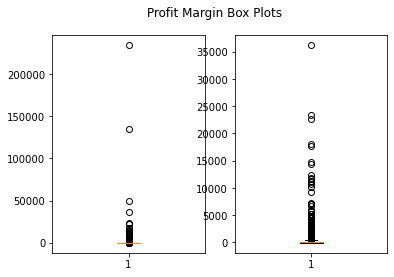

In [26]:
reasonableBudget = subDataSet[subDataSet['budget']>=1000]

print(reasonableBudget['BoxOfficeProfitMargin'].describe())

fig, (ax1, ax2)= plt.subplots(1,2)
fig.suptitle('Profit Margin Box Plots')
ax1.boxplot(reasonableBudget['BoxOfficeProfitMargin'].dropna())
ax2.boxplot(reasonableBudget[reasonableBudget['BoxOfficeProfitMargin']<50000]['BoxOfficeProfitMargin'])
plt.show()

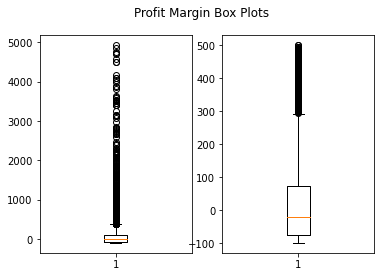

Number of outliers above 1.5*IQR + Median = 605


In [27]:
fig, (ax1, ax2)= plt.subplots(1,2)
fig.suptitle('Profit Margin Box Plots')
ax1.boxplot(reasonableBudget[reasonableBudget['BoxOfficeProfitMargin']<5000]['BoxOfficeProfitMargin'])
ax2.boxplot(reasonableBudget[reasonableBudget['BoxOfficeProfitMargin']<500]['BoxOfficeProfitMargin'])
plt.show()

Q1 = reasonableBudget['BoxOfficeProfitMargin'].quantile(0.25)
Q3 = reasonableBudget['BoxOfficeProfitMargin'].quantile(0.75)
IQR = Q3 - Q1

print("Number of outliers above 1.5*IQR + Median = {0}".format(len(reasonableBudget[reasonableBudget['BoxOfficeProfitMargin']> Q3+1.5*IQR])))

### Look for high outliers

In [28]:
highEarningMovies = reasonableBudget[reasonableBudget['BoxOfficeProfitMargin']> Q3+1.5*IQR]
print(highEarningMovies['BoxOfficeProfitMargin'].describe())

highQ1 = highEarningMovies['BoxOfficeProfitMargin'].quantile(0.25)
highQ3 = highEarningMovies['BoxOfficeProfitMargin'].quantile(0.75)
highIQR = highQ3 - highQ1
print()
print("Number of outliers in distribution of high earning movies above 1.5*IQR + Median = {0}".format(len(reasonableBudget[reasonableBudget['BoxOfficeProfitMargin']> highQ3+1.5*highIQR])))


NinPercentile = highEarningMovies['BoxOfficeProfitMargin'].quantile(0.99)
print("Number of movies above 99% of high earning movies = {0}".format(len(highEarningMovies[highEarningMovies['BoxOfficeProfitMargin']>NinPercentile])))

highEarningMovies[highEarningMovies['BoxOfficeProfitMargin']>NinPercentile][['title','release_date','budget','Domestic','BoxOfficeProfitMargin']]

count       605.000000
mean       2205.325164
std       11391.435957
min         380.553320
25%         508.441074
50%         734.083323
75%        1420.827400
max      234131.831667
Name: BoxOfficeProfitMargin, dtype: float64

Number of outliers in distribution of high earning movies above 1.5*IQR + Median = 69
Number of movies above 99% of high earning movies = 7


,title,release_date,budget,Domestic,BoxOfficeProfitMargin
1247,The Texas Chain Saw Massacre,1974-10-01,85000.0,30859000.0,36204.705882
1395,The Blair Witch Project,1999-07-14,60000.0,140539099.0,234131.831667
2638,Joe,1970-07-15,106000.0,19319254.0,18125.711321
4050,Open Water,2004-08-06,130000.0,30610863.0,23446.817692
5055,One Missed Call,2008-01-04,20000.0,26890041.0,134350.205000
5622,Paranormal Activity,2007-09-14,215000.0,107918810.0,50094.795349
8783,The Gallows,2015-07-10,100000.0,22764410.0,22664.410000


count      6359.000000
mean        217.931764
std        3571.208795
min         -99.998500
25%         -72.966823
50%          -9.299957
75%         108.389800
max      234131.831667
Name: BoxOfficeProfitMargin, dtype: float64

DataSet with Domestic profit Margin< 99% of High Earning Films count: 6352


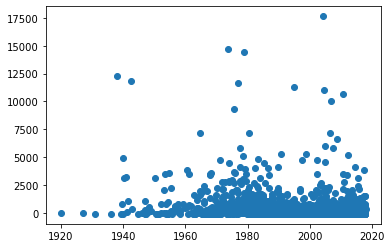

In [29]:
print(reasonableBudget['BoxOfficeProfitMargin'].describe())
print()

nonOutliers = reasonableBudget[reasonableBudget['BoxOfficeProfitMargin']< NinPercentile]
print("DataSet with Domestic profit Margin< 99% of High Earning Films count: {0}".format(len(nonOutliers)))
plt.scatter(nonOutliers['release_date'],nonOutliers['BoxOfficeProfitMargin'])
plt.show()

### Write out Data Wrangled sets

In [30]:
marginFile = "resonableBudget.csv"
reasonableBudget = reasonableBudget.drop_duplicates('id')
reasonableBudget.to_csv(marginFile, sep=',', index=False)

subDataFile = "dataProfitMarginSubset.csv"
subDataSet = subDataSet.drop_duplicates('id')
subDataSet.to_csv(subDataFile, sep=',', index=False)

allDataFile = "allData.csv"
dataSetWithMargins = dataSetWithMargins.drop_duplicates('id')
dataSetWithMargins.to_csv(allDataFile, sep=',', index=False)

### Separate Production Companies

In [38]:
import ast
prodCompaniesDF = pd.DataFrame(columns=subDataSet.columns)

if(not exists('./movieData_SeparatedProductionCompanies.csv')):
    for i in range(len(subDataSet)):
        row = subDataSet.iloc[i]
        if row['production_companies'] == None or len(row['production_companies'])==0:
            continue
        prodComp = ast.literal_eval(row['production_companies'])
        for comp in prodComp:
            copyRow = row.copy()
            copyRow['ProductionCompany_Name'] = comp['name']
            copyRow['ProductionCompany_Id'] = comp['id']
            prodCompaniesDF= prodCompaniesDF.append(copyRow)
            
    prodFile = "movieData_SeparatedProductionCompanies.csv"
    reasonableBudget.to_csv(prodFile, sep=',', index=False)